In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from ray import tune
from ray import train
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\TonVo\anaconda3\envs\myenv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
torch.manual_seed(2023)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data = pd.read_excel('dataset_final.xlsx')
data = data.dropna(thresh=len(data.columns)-10)
data = data.fillna(method='ffill')
data.tail()

C:\Users\TonVo\AppData\Local\Temp\ipykernel_25332\2340567172.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


,DATE,NASDAQ100,NASDAQCOM,WILL5000PR,DAAA,DCOILWTICO,DGS30,DPRIME,T10Y2Y,T10Y3M,...,VOLUME,RETURN,ADL,WR,RVI,EMA,TR,UO,AAPL,MSFT
9788,2023-09-19,15191.23,13678.19,44733.86,5.10,91.16,4.43,8.5,-0.71,-1.17,...,3.614880e+09,-0.002151,2.153461e+12,-78.0646,0.6052,4463.8448,36.9199,4.2918,179.070007,328.649994
9789,2023-09-20,14969.92,13469.13,44327.34,5.07,89.20,4.40,8.5,-0.77,-1.21,...,3.308450e+09,-0.009395,2.150244e+12,-99.4135,0.3447,4455.6255,59.6499,2.5001,175.490005,320.769989
9790,2023-09-21,14694.24,13223.98,43579.31,5.21,89.56,4.56,8.5,-0.63,-1.08,...,3.662340e+09,-0.016401,2.146712e+12,-99.6086,0.2868,4438.8754,73.0303,0.6814,173.929993,319.529999
9791,2023-09-22,14701.10,13211.81,43482.13,5.15,90.00,4.53,8.5,-0.66,-1.12,...,3.349570e+09,-0.002296,2.143947e+12,-98.1952,0.2777,4423.0334,40.9097,0.1672,174.789993,317.010010
9792,2023-09-25,14768.90,13271.32,43654.44,5.29,89.68,4.67,8.5,-0.54,-1.03,...,3.195650e+09,0.004023,2.146952e+12,-83.4011,0.4286,4411.6209,35.8096,0.0924,176.080002,317.540009


In [4]:
def split_data(data, lookback):
    data_raw = data.to_numpy()
    X_list = []
    y_list = []

    for index in range(len(data_raw) - lookback): 
        X_list.append(data_raw[index: index + lookback, 1:])
        y_list.append(data_raw[index + lookback, -9])

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y

lookback = 14

X, y = split_data(data, lookback)

In [5]:
train_length = int(len(X) * 0.85)
val_length = int(len(X) * 0.05)
test_length = len(X) - train_length - val_length

In [6]:
X_train = X[:train_length]
y_train = y[:train_length]

X_val = X[train_length:train_length+val_length]
y_val = y[train_length:train_length+val_length]

X_test = X[train_length+val_length:]
y_test = y[train_length+val_length:]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_2D = X_train.reshape(-1, X_train.shape[-1])

X_train_scaled_2D = scaler.fit_transform(X_train_2D)

X_train_scaled = X_train_scaled_2D.reshape(X_train.shape)

X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [8]:
X_train_t = torch.tensor(X_train_scaled).float()
y_train_t = torch.tensor(y_train).float()

X_val_t = torch.tensor(X_val_scaled).float()
y_val_t = torch.tensor(y_val).float()

X_test_t = torch.tensor(X_test_scaled).float()
y_test_t = torch.tensor(y_test).float()

In [9]:
config = {
    "lr": tune.loguniform(1e-5, 1e-3),
    "batch_size": tune.choice([16, 32, 64, 128]),
    "hidden_dims": tune.grid_search([[256, 128], [512, 128], [512, 256, 128], [256, 512, 256, 128], [128, 256, 512, 128]]),
    "num_epochs": tune.choice([30, 50, 75, 100, 150])
}

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(LSTMModel, self).__init__()

        self.lstm_layers = nn.ModuleList()

        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dims[0], batch_first=True))

        for i in range(1, len(hidden_dims)):
            self.lstm_layers.append(nn.LSTM(hidden_dims[i-1], hidden_dims[i], batch_first=True))

        self.fc1 = nn.Linear(hidden_dims[-1], 64)
        self.leakyrelu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        
        x = x[:, -1, :]

        x = self.fc1(x)
        x = self.leakyrelu1(x)
        x = self.fc2(x)
        
        return x

In [11]:
def madl_loss(y_true, y_pred):
    N = y_true.size(0)
    sign = torch.sign(y_true * y_pred)
    loss = (1 - sign) * torch.abs(y_true - y_pred)
    return torch.sum(loss) / N

In [12]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(X_train_t, y_train_t)
val_data = TensorDataset(X_val_t, y_val_t)

In [13]:
model = LSTMModel(22, [256, 512, 256, 128], 1).to(device)

model.load_state_dict(torch.load(r"")) # replace with your path

<All keys matched successfully>

In [14]:
model.train()

LSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(22, 256, batch_first=True)
    (1): LSTM(256, 512, batch_first=True)
    (2): LSTM(512, 256, batch_first=True)
    (3): LSTM(256, 128, batch_first=True)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (leakyrelu1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)

X_test_subset = X_test_t[:150]

output = model(X_test_subset.to(device)).squeeze(-1)

baseline = torch.median(X_test_subset, dim=0).values.unsqueeze(0)

attr, delta = ig.attribute(X_test_subset.to(device), baselines=baseline.to(device), return_convergence_delta=True)

attr_positive = attr[output > 0]
attr_negative = attr[output <= 0]

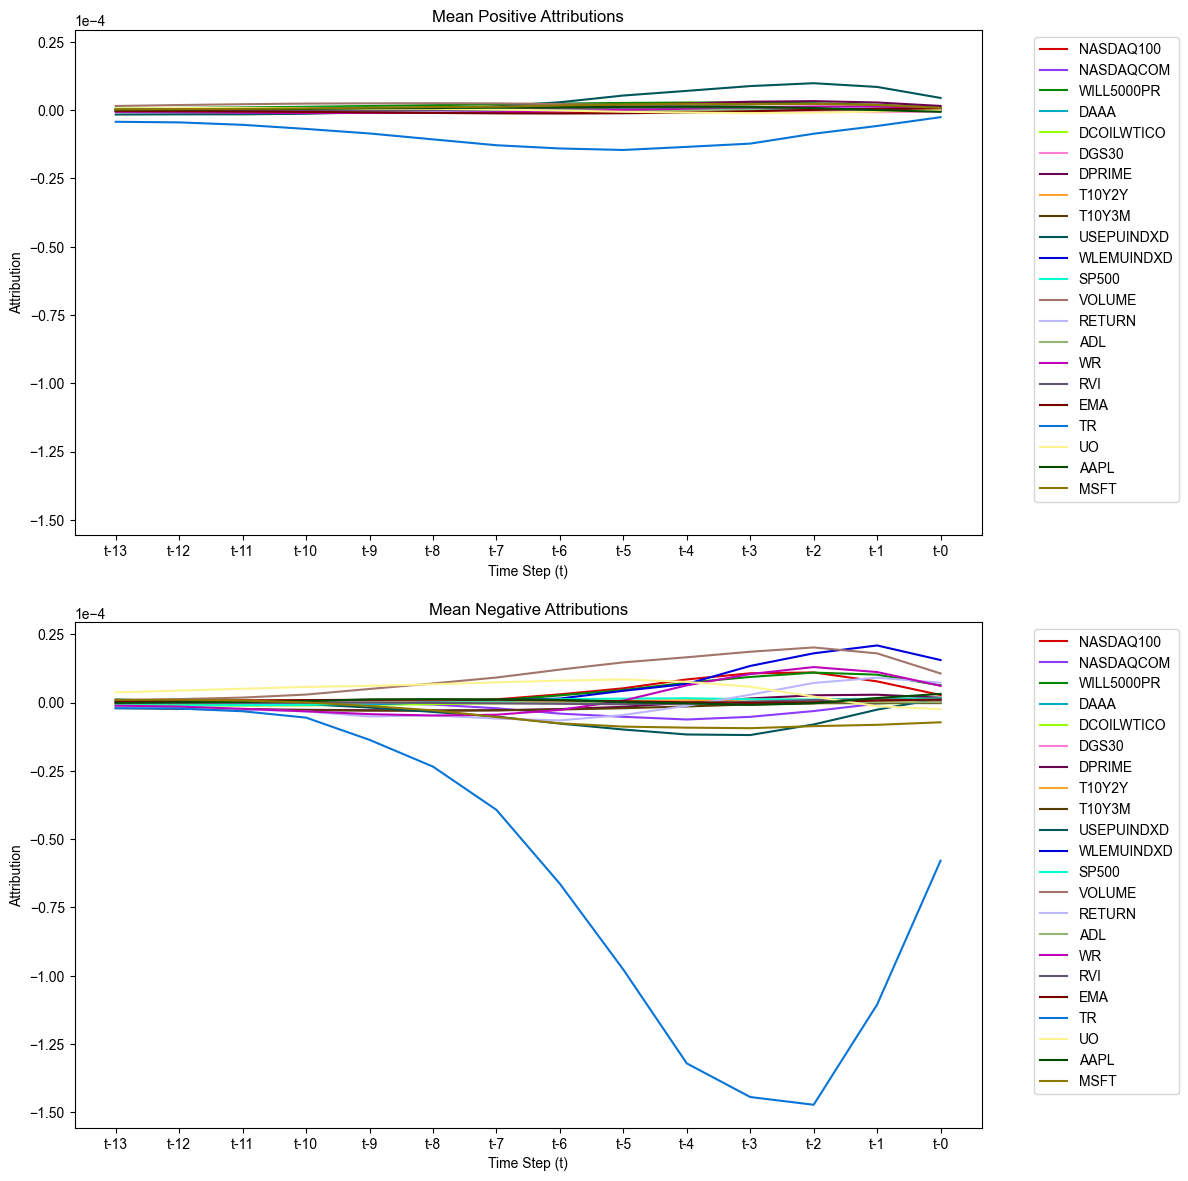

In [16]:
import colorcet as cc

attr_positive_mean = attr_positive.mean(dim=0).cpu().numpy()
attr_negative_mean = attr_negative.mean(dim=0).cpu().numpy()

feature_names = ['NASDAQ100', 'NASDAQCOM', 'WILL5000PR', 'DAAA', 'DCOILWTICO',
                 'DGS30', 'DPRIME', 'T10Y2Y', 'T10Y3M', 'USEPUINDXD', 'WLEMUINDXD',
                 'SP500', 'VOLUME', 'RETURN', 'ADL', 'WR', 'RVI', 'EMA', 'TR', 'UO',
                 'AAPL', 'MSFT']

num_features = len(feature_names)
num_timesteps = attr_positive_mean.shape[0]

fig, axs = plt.subplots(2, figsize=(12, 12), sharey=True)

cmap = sns.color_palette(cc.glasbey, n_colors=num_features)

for i in range(num_features):
    sns.lineplot(x=range(num_timesteps), y=attr_positive_mean[:, i], ax=axs[0], label=feature_names[i], color=cmap[i])
axs[0].set_title('Mean Positive Attributions')
axs[0].set_xlabel('Time Step (t)')
axs[0].set_ylabel('Attribution')
axs[0].set_xticks(range(num_timesteps))
axs[0].set_xticklabels([f't-{num_timesteps - i - 1}' for i in range(num_timesteps)])
axs[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

for i in range(num_features):
    sns.lineplot(x=range(num_timesteps), y=attr_negative_mean[:, i], ax=axs[1], label=feature_names[i], color=cmap[i])
axs[1].set_title('Mean Negative Attributions')
axs[1].set_xlabel('Time Step (t)')
axs[1].set_ylabel('Attribution')
axs[1].set_xticks(range(num_timesteps))
axs[1].set_xticklabels([f't-{num_timesteps - i - 1}' for i in range(num_timesteps)])
axs[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

sns.set_style('darkgrid')

plt.tight_layout()
plt.savefig('integrated_gradients_pos_vs_neg.svg')
plt.show()

C:\Users\TonVo\AppData\Local\Temp\ipykernel_25332\3377050760.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[0], x='Importance', y='Feature', data=data_positive, palette='viridis_r')
C:\Users\TonVo\AppData\Local\Temp\ipykernel_25332\3377050760.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[1], x='Importance', y='Feature', data=data_negative, palette='viridis_r')


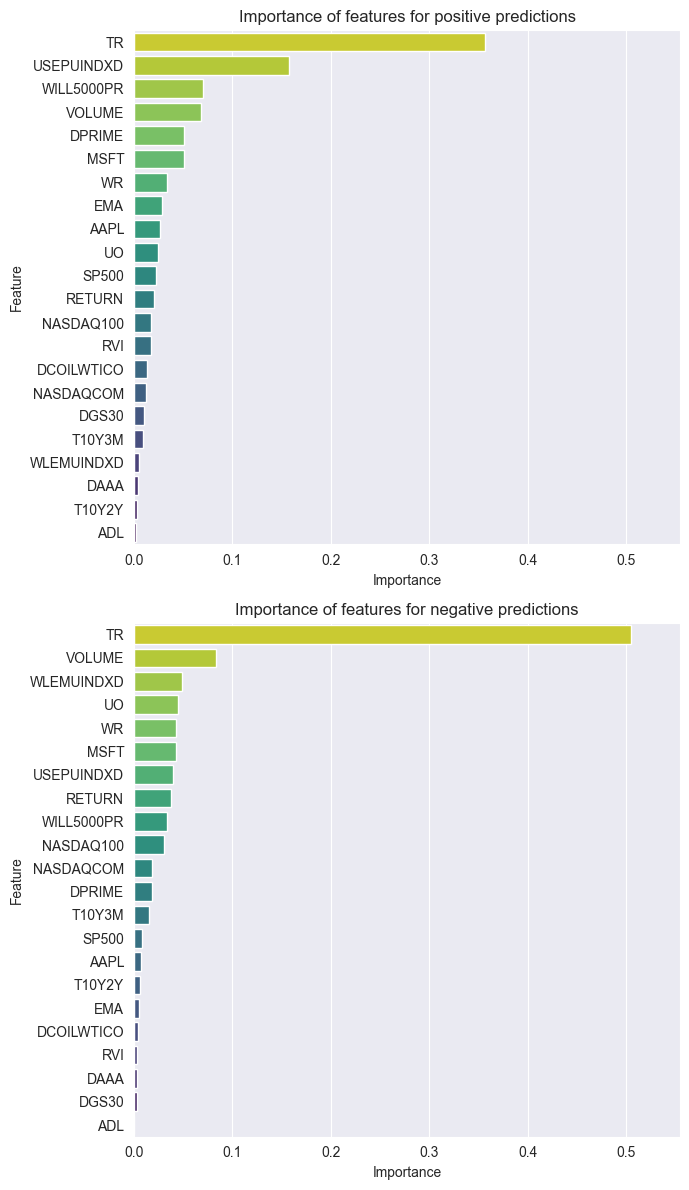

In [22]:
attr_positive_mean_tensor = torch.from_numpy(attr_positive_mean)
attr_negative_mean_tensor = torch.from_numpy(attr_negative_mean)

attributions_sum_positive = torch.sum(torch.abs(attr_positive_mean_tensor), dim=0)
attributions_sum_negative = torch.sum(torch.abs(attr_negative_mean_tensor), dim=0)

attributions_normalized_positive = attributions_sum_positive / torch.sum(attributions_sum_positive)
attributions_normalized_negative = attributions_sum_negative / torch.sum(attributions_sum_negative)

feature_names = ['NASDAQ100', 'NASDAQCOM', 'WILL5000PR', 'DAAA', 'DCOILWTICO',
                 'DGS30', 'DPRIME', 'T10Y2Y', 'T10Y3M', 'USEPUINDXD', 'WLEMUINDXD',
                 'SP500', 'VOLUME', 'RETURN', 'ADL', 'WR', 'RVI', 'EMA', 'TR', 'UO',
                 'AAPL', 'MSFT']

import pandas as pd
data_positive = pd.DataFrame({'Feature': feature_names, 'Importance': attributions_normalized_positive.numpy()})
data_negative = pd.DataFrame({'Feature': feature_names, 'Importance': attributions_normalized_negative.numpy()})

data_positive = data_positive.sort_values(by='Importance', ascending=False)
data_negative = data_negative.sort_values(by='Importance', ascending=False)

fig, axs = plt.subplots(2, figsize=(7, 12))

max_value = max(data_positive['Importance'].max(), data_negative['Importance'].max())

sns.barplot(ax=axs[0], x='Importance', y='Feature', data=data_positive, palette='viridis_r')
axs[0].set_title('Importance of features for positive predictions')
axs[0].set_xlim([0, max_value+0.05])

sns.barplot(ax=axs[1], x='Importance', y='Feature', data=data_negative, palette='viridis_r')
axs[1].set_title('Importance of features for negative predictions')
axs[1].set_xlim([0, max_value+0.05])

plt.tight_layout()
plt.savefig('integrated_gradients_pos_vs_neg_sorted.svg')
plt.show()